In [146]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib

matplotlib.rcParams['figure.figsize'] = (20,10)

In [147]:
# Read CSV file into dataframe
# (Bangalore housing data from Kaggle)
# https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data
path = 'data/Bengaluru_House_Data.csv'
df = pd.read_csv(path)
print("Shape:", df.shape)
df.head()

Shape: (13320, 9)


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


* Start by exploring the dataset

In [148]:
# Examine some of the columns
for col in ('area_type', 'availability', 'location', 'society'):
    print(df.groupby(col)[col].agg('count').sort_values(ascending=False)[:5], '\n')

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64 

availability
Ready To Move    10581
18-Dec             307
18-May             295
18-Apr             271
18-Aug             200
Name: availability, dtype: int64 

location
Whitefield         540
Sarjapur  Road     399
Electronic City    302
Kanakpura Road     273
Thanisandra        234
Name: location, dtype: int64 

society
GrrvaGr    80
PrarePa    76
Sryalan    59
Prtates    59
GMown E    56
Name: society, dtype: int64 



In [149]:
# Select and rename relevant columns
df.drop(['area_type', 'society', 'balcony', 'availability'], axis='columns', inplace=True)
df.rename(columns={'total_sqft': 'square_feet', 'size': 'bedrooms', 'bath': 'bathrooms'}, inplace=True)
df.head()

,location,bedrooms,square_feet,bathrooms,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


In [150]:
# Examine the number of null values
df.isnull().sum()

location        1
bedrooms       16
square_feet     0
bathrooms      73
price           0
dtype: int64

In [151]:
# Since there are only a few, drop them
df.dropna(inplace=True)
df.shape

(13246, 5)

In [152]:
# Examine bedrooms values
df['bedrooms'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

In [153]:
import re

# Convert column into numerical values
def extract_num_bedrooms(bedrooms):
    match = re.search('^(\d*) ', bedrooms)
    num_bedrooms = match.group(1) if match is not None else 0
    return int(num_bedrooms)

df['bedrooms'] = df['bedrooms'].apply(extract_num_bedrooms)
df.head()

,location,bedrooms,square_feet,bathrooms,price
0,Electronic City Phase II,2,1056,2.0,39.07
1,Chikka Tirupathi,4,2600,5.0,120.00
2,Uttarahalli,3,1440,2.0,62.00
3,Lingadheeranahalli,3,1521,3.0,95.00
4,Kothanur,2,1200,2.0,51.00


In [154]:
# Explore square feet
df['square_feet'].unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [155]:
# Convert column into consistent numerical values
unit_map = {'Sq. Meter': 10.7639,
                'Sq. Yards': 9,
                'Acres': 43560,
                'Perch': 272.25,
                'Cents': 435.56,
                'Grounds': 2400,
                'Guntha': 1089}

def extract_square_feet(square_feet):
    if re.match('^\d+\.?\d*$', square_feet):
        return float(square_feet)
    # If the value is a range, return the median
    if re.search(' - ', square_feet):
        match = re.match('^(\d+\.?\d*) - (\d+\.?\d*)$', square_feet)
        return (float(match.group(1)) + float(match.group(2))) / 2
    # Extract the number and type of units and refer to the above mapping
    match = re.match('^(\d+\.?\d*)(\D+)$', square_feet)
    num, unit = float(match.group(1)), match.group(2)
    if unit in unit_map:
        return num * unit_map[unit]
    else:
        return 0

df['square_feet'] = df['square_feet'].apply(extract_square_feet)
df.head()

,location,bedrooms,square_feet,bathrooms,price
0,Electronic City Phase II,2,1056.0,2.0,39.07
1,Chikka Tirupathi,4,2600.0,5.0,120.00
2,Uttarahalli,3,1440.0,2.0,62.00
3,Lingadheeranahalli,3,1521.0,3.0,95.00
4,Kothanur,2,1200.0,2.0,51.00


* Feature Engineering

In [156]:
# Add price per square foot category
df['price_per_sq'] = df['price'] * 100000 / df['square_feet'] #convert from lakh rupees to rupees
df.head()

,location,bedrooms,square_feet,bathrooms,price,price_per_sq
0,Electronic City Phase II,2,1056.0,2.0,39.07,3699.810606
1,Chikka Tirupathi,4,2600.0,5.0,120.00,4615.384615
2,Uttarahalli,3,1440.0,2.0,62.00,4305.555556
3,Lingadheeranahalli,3,1521.0,3.0,95.00,6245.890861
4,Kothanur,2,1200.0,2.0,51.00,4250.000000


In [157]:
# Remove whitespace and capitalization from location category and count results
df['location'] = df['location'].apply(lambda x: x.strip().lower())
location_stats = df.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
whitefield               535
sarjapur  road           392
electronic city          304
kanakpura road           266
thanisandra              236
                        ... 
kamanahalli main road      1
kamdhenu nagar             1
1 giri nagar               1
kanakadasa layout          1
zuzuvadi                   1
Name: location, Length: 1282, dtype: int64

In [158]:
# Replace location categories with fewer than 10 instances with "other"
rare_locations = location_stats[location_stats < 10]
df['location'] = df['location'].apply(lambda x: 'other' if x in rare_locations else x)
len(df['location'].unique())

255

In [159]:
# Determine how many price per square feet outliers there are (for each location)
g = df.groupby('location')['price_per_sq']
q1, q3 = g.quantile(.25), g.quantile(.75)
lower_limit, upper_limit = q1 - 1.5 * (q3 - q1), q3 + 1.5 * (q3 - q1)
lower_limit.name = 'location_lower_limit'
upper_limit.name = 'location_upper_limit'
df2 = df.set_index('location').join(lower_limit).join(upper_limit).reset_index()
def get_outliers(row):
    if row['location_lower_limit'] > row['price_per_sq']:
        row['outlier_status'] = 'low'
    elif row['location_upper_limit'] < row['price_per_sq']:
        row['outlier_status'] = 'high'
    else:
        row['outlier_status'] = 'normal'
    return row
df2 = df2.apply(get_outliers, axis=1)
df2.groupby('outlier_status')['outlier_status'].agg('count')

outlier_status
high        822
low          80
normal    12344
Name: outlier_status, dtype: int64

In [160]:
df2 = df2[df2['outlier_status'] == 'normal'].drop(['outlier_status', 'location_lower_limit', 'location_upper_limit'], axis='columns')
df2.head()

,location,bedrooms,square_feet,bathrooms,price,price_per_sq
0,1st block jayanagar,4,2850.0,4.0,428.0,15017.543860
1,1st block jayanagar,3,1630.0,3.0,194.0,11901.840491
2,1st block jayanagar,6,1200.0,6.0,125.0,10416.666667
3,1st block jayanagar,3,1875.0,2.0,235.0,12533.333333
4,1st block jayanagar,4,2400.0,4.0,450.0,18750.000000


In [161]:
# Remove instances with erroneously small bedrooms

df2 = df2[df2['square_feet'] / df2['bedrooms'] >= 300]
df2.shape

(11824, 6)

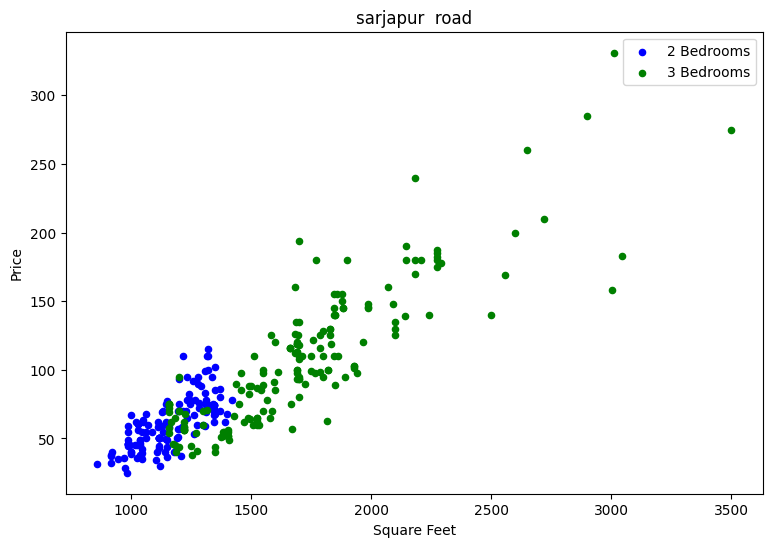

In [162]:
# Draw a scatter plot to gain a sense of the relationship between
# price, square feet and number of bedrooms per location
def plot_bedrooms_size_price(df, location):
    two_bedrooms = df[(df['location'] == location) & (df['bedrooms'] == 2)]
    three_bedrooms = df[(df['location'] == location) & (df['bedrooms'] == 3)]
    matplotlib.rcParams['figure.figsize'] = (9, 6)
    plt.scatter(two_bedrooms['square_feet'], two_bedrooms['price'],
                color='blue', label='2 Bedrooms', s=20)
    plt.scatter(three_bedrooms['square_feet'], three_bedrooms['price'],
                color='green', label='3 Bedrooms', s=20)
    plt.xlabel('Square Feet')
    plt.ylabel('Price')
    plt.title(location)
    plt.legend()

loc =  df2.groupby('location')['location'].agg('count').sort_values().index.values[-3]
plot_bedrooms_size_price(df2, loc)

Text(0.5, 0, 'Price Per Square Foot')

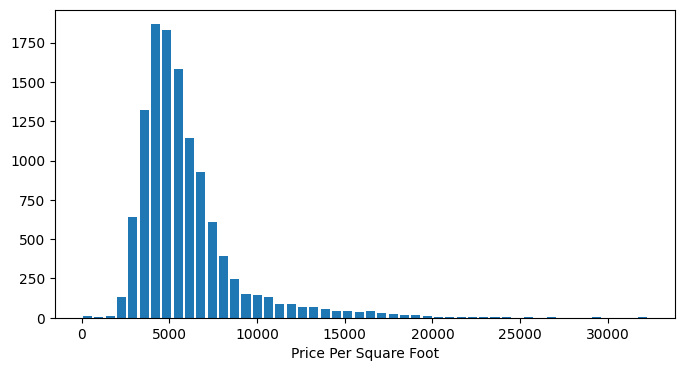

In [163]:
# Plot the distribution of price per square foot
matplotlib.rcParams['figure.figsize'] = (8,4)
plt.hist(df2['price_per_sq'], bins=50, rwidth=.8)
plt.xlabel('Price Per Square Foot')

In [164]:
# Remove homes in which number of bathrooms two or more greather than number of bedrooms
# Remove price per square foot features
print(df2.shape)
df2 = df2[df2['bedrooms'] + 2 > df2['bathrooms']].drop('price_per_sq', axis='columns')
print(df2.shape)

(11824, 6)
(11705, 5)


* Build and train model

In [165]:
# Use One Hot encoding for location feature
location_matrix = pd.get_dummies(df2['location'])
location_matrix.head()

,1st block jayanagar,1st block koramangala,1st phase jp nagar,2nd phase judicial layout,2nd stage nagarbhavi,5th block hbr layout,5th phase jp nagar,6th phase jp nagar,7th phase jp nagar,8th phase jp nagar,...,vijayanagar,vishveshwarya layout,vishwapriya layout,vittasandra,whitefield,yelachenahalli,yelahanka,yelahanka new town,yelenahalli,yeshwanthpur
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [166]:
# Remove others category from location matrix and location category from dataframe 
# and concatenate them into a single dataframe
df_prepared = pd.concat([df2.drop('location', axis='columns'), 
                         location_matrix.drop('other', axis='columns')], 
                        axis='columns')
print(df_prepared.shape)
df_prepared.head()

(11705, 258)


,bedrooms,square_feet,bathrooms,price,1st block jayanagar,1st block koramangala,1st phase jp nagar,2nd phase judicial layout,2nd stage nagarbhavi,5th block hbr layout,...,vijayanagar,vishveshwarya layout,vishwapriya layout,vittasandra,whitefield,yelachenahalli,yelahanka,yelahanka new town,yelenahalli,yeshwanthpur
0,4,2850.0,4.0,428.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3,1630.0,3.0,194.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,1875.0,2.0,235.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,4,2400.0,4.0,450.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,2,1000.0,3.0,60.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [167]:
# Split into train and test sets, stratified by location
from sklearn.model_selection import train_test_split
X, y = df_prepared.drop('price', axis='columns'), df_prepared['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=0, stratify=df2['location']
)
print(X_train.shape)
X_train.head()

(9364, 257)


,bedrooms,square_feet,bathrooms,1st block jayanagar,1st block koramangala,1st phase jp nagar,2nd phase judicial layout,2nd stage nagarbhavi,5th block hbr layout,5th phase jp nagar,...,vijayanagar,vishveshwarya layout,vishwapriya layout,vittasandra,whitefield,yelachenahalli,yelahanka,yelahanka new town,yelenahalli,yeshwanthpur
12678,3,1836.0,3.0,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
9568,2,1128.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10934,2,1200.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10044,3,1270.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9579,2,1170.0,2.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Root Mean Squared Error: 78.33999939917824
Mean Absolute Error: 36.320673105032114
Score: 0.41994993439112327


(0.0, 400.0)

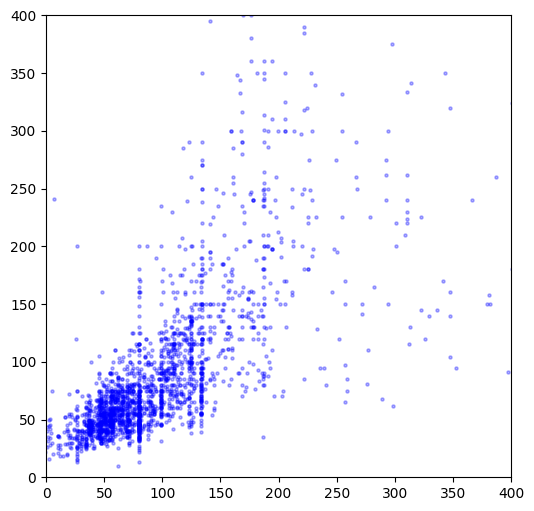

In [168]:
# Train and evaluate a basic linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
rmse, mae = mean_squared_error(y_test, y_pred, squared=False), mean_absolute_error(y_test, y_pred)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Score:", lr_clf.score(X_test, y_test))
matplotlib.rcParams['figure.figsize'] = (6,6)
plt.scatter(y_pred, y_test, color='blue', s=5, alpha=.3)
plt.xlim(0, 400)
plt.ylim(0, 400)

In [169]:
# Evaluate the model using cross validation
from sklearn.model_selection import ShuffleSplit, cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)
cross_val_score(LinearRegression(), X, y, cv=cv)


array([0.45818935, 0.47024973, 0.47715226, 0.49289378, 0.42764391])

In [170]:
# Try getting a better result by removing more outliers: let's eliminate instances
# whose prices are not within a standard deviation of their location mean
g = df.groupby('location')['price_per_sq']
mean, std = g.mean(), g.std()
lower_limit, upper_limit = mean - std, mean + std
lower_limit.name = 'location_lower_limit'
upper_limit.name = 'location_upper_limit'
df3 = df.set_index('location').join(lower_limit).join(upper_limit).reset_index()
def get_outliers(row):
    if row['location_lower_limit'] > row['price_per_sq']:
        row['outlier_status'] = 'low'
    elif row['location_upper_limit'] < row['price_per_sq']:
        row['outlier_status'] = 'high'
    else:
        row['outlier_status'] = 'normal'
    return row
df3 = df3.apply(get_outliers, axis=1)
df3.groupby('outlier_status')['outlier_status'].agg('count')

outlier_status
high       1113
low         640
normal    11493
Name: outlier_status, dtype: int64

10917
(10917, 257) (10917,)
Root Mean Squared Error: 126.83097680736947
Mean Absolute Error: 44.25121456495353
Score: 0.2870749680475553


(0.0, 400.0)

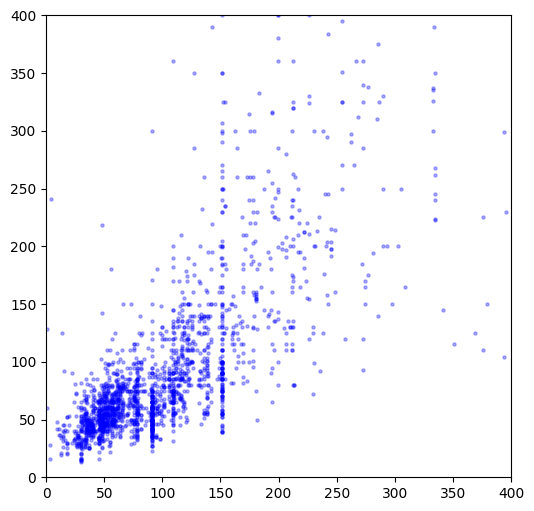

In [171]:
df3 = df3[df3['outlier_status'] == 'normal'].drop(['outlier_status', 'location_lower_limit', 'location_upper_limit'], axis='columns')
df3 = df3[df3['square_feet'] / df3['bedrooms'] >= 300]
df3 = df3[df3['bedrooms'] + 2 > df3['bathrooms']].drop('price_per_sq', axis='columns')
location_matrix = pd.get_dummies(df3['location'])
df3_prepared = pd.concat([df3.drop('location', axis='columns'), 
                         location_matrix.drop('other', axis='columns')], 
                        axis='columns')
print(len(df3['location']))
X, y = df3_prepared.drop('price', axis='columns'), df3_prepared['price']
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2, random_state=0, stratify=df3['location']
)
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
rmse, mae = mean_squared_error(y_test, y_pred, squared=False), mean_absolute_error(y_test, y_pred)
print("Root Mean Squared Error:", rmse)
print("Mean Absolute Error:", mae)
print("Score:", lr_clf.score(X_test, y_test))
matplotlib.rcParams['figure.figsize'] = (6,6)
plt.scatter(y_pred, y_test, color='blue', s=5, alpha=.3)
plt.xlim(0, 400)
plt.ylim(0, 400)

In [191]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor

def find_best_model(X, y):
    algos = {
        'linear_regression': {
            'model': LinearRegression(),
            'params': {'fit_intercept': [True, False]}
        },
        'lasso': {
            'model': Lasso(),
            'params': {'alpha': [1, 2], 'selection': ['random', 'cyclic']}
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'], 
                'splitter': ['random', 'best'],
                'max_depth': [4, 6, 9]
                }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=.2, random_state=0)
    for algo, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({'model': algo, 'best_score': gs.best_score_, 'best_params': gs.best_params_})
    return pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])


In [192]:
# Try the new model on several versions of the data set
find_best_model(df_prepared.drop('price', axis='columns'), df2['price'])

,model,best_score,best_params
0,linear_regression,0.465226,{'fit_intercept': True}
1,lasso,0.326517,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.639540,"{'criterion': 'friedman_mse', 'max_depth': 9, ..."


In [189]:
find_best_model(df3_prepared.drop('price', axis='columns'), df3['price'])

,model,best_score,best_params
0,linear_regression,0.321530,{'fit_intercept': True}
1,lasso,0.239958,"{'alpha': 1, 'selection': 'random'}"
2,decision_tree,0.540760,"{'criterion': 'friedman_mse', 'max_depth': 3, ..."


In [190]:
find_best_model(df.drop(['price', 'price_per_sq', 'location'], axis='columns'), df['price'])

,model,best_score,best_params
0,linear_regression,0.237806,{'fit_intercept': True}
1,lasso,0.237396,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.514323,"{'criterion': 'squared_error', 'max_depth': 3,..."


In [198]:
# Choose model
dc_reg = DecisionTreeRegressor(criterion='friedman_mse', splitter='best', max_depth=9)
dc_reg.fit(df_prepared.drop('price', axis='columns'), df2['price'])

def predict_price(bedrooms, square_feet, bathrooms, location):
    cols = df_prepared.drop('price', axis='columns').columns
    location = location.strip().lower()
    loc_index = np.where(cols == location)[0][0]
    x = np.zeros(len(cols))
    x[0], x[1], x[2] = bedrooms, square_feet, bathrooms
    if loc_index >= 0:
        x[loc_index] = 1
    return dc_reg.predict([x])[0]

In [199]:
[predict_price(2, 1300, 2, '1st Phase JP Nagar'),
predict_price(3, 1300, 2, '1st Phase JP Nagar'),
predict_price(3, 2700, 2, '1st Phase JP Nagar'),
predict_price(2, 1300, 2, 'Indira Nagar'),
predict_price(3, 1300, 2, 'Indira Nagar'),
predict_price(3, 2700, 2, 'Indira Nagar')]

/Users/alexkelber/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/alexkelber/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/alexkelber/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/alexkelber/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
/Users/alexkelber/.pyenv/versions/3.11.0/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but

[68.39102820025337,
 68.39102820025337,
 194.64123244929797,
 68.39102820025337,
 68.39102820025337,
 327.0]

In [203]:
import pickle
with open('models/bangalore_housing_predictions.pickle', 'wb') as f:
    pickle.dump(dc_reg, f)

In [204]:
import json
cols = {
    'data_columns': [col.lower() for col in df_prepared.drop('price', axis='columns').columns]
}
with open('models/bangalore_housing_columns.json', 'w') as f:
    f.write(json.dumps(cols))